In [1]:
import geopandas as gpd
import numpy as np
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import pandas as pd
import rasterio
from shapely.geometry import Point, box
import os

In [2]:
# data_nyc\zones.geojson

zone = gpd.read_file('../data_nyc/zones.geojson')
zone = zone.reset_index(drop=True)
zone.head()

,ZONEDIST,date,time,geometry
0,['R3A' 'PARK'],2024-01-01,0:00,"POLYGON ((913013.301 118296.425, 916294.141 11..."
1,['R3A' 'PARK'],2024-01-01,1:00,"POLYGON ((913013.301 118296.425, 916294.141 11..."
2,['R3A' 'PARK'],2024-01-01,2:00,"POLYGON ((913013.301 118296.425, 916294.141 11..."
3,['R3A' 'PARK'],2024-01-01,3:00,"POLYGON ((913013.301 118296.425, 916294.141 11..."
4,['R3A' 'PARK'],2024-01-01,4:00,"POLYGON ((913013.301 118296.425, 916294.141 11..."


In [3]:
minx, miny, maxx, maxy = zone.total_bounds
minx, miny, maxx, maxy

(np.float64(913013.300598219),
 np.float64(118296.42454648018),
 np.float64(1067212.7805982193),
 np.float64(272495.9045464802))

In [4]:
temp = zone.copy()
temp

# save temp
# temp.to_file('../data_nyc/temp.geojson', driver='GeoJSON')

,ZONEDIST,date,time,geometry
0,['R3A' 'PARK'],2024-01-01,0:00,"POLYGON ((913013.301 118296.425, 916294.141 11..."
1,['R3A' 'PARK'],2024-01-01,1:00,"POLYGON ((913013.301 118296.425, 916294.141 11..."
2,['R3A' 'PARK'],2024-01-01,2:00,"POLYGON ((913013.301 118296.425, 916294.141 11..."
3,['R3A' 'PARK'],2024-01-01,3:00,"POLYGON ((913013.301 118296.425, 916294.141 11..."
4,['R3A' 'PARK'],2024-01-01,4:00,"POLYGON ((913013.301 118296.425, 916294.141 11..."
...,...,...,...,...
9648907,[ NaN ],2024-06-30,19:00,"POLYGON ((1063931.941 269215.065, 1067212.781 ..."
9648908,[ NaN ],2024-06-30,20:00,"POLYGON ((1063931.941 269215.065, 1067212.781 ..."
9648909,[ NaN ],2024-06-30,21:00,"POLYGON ((1063931.941 269215.065, 1067212.781 ..."
9648910,[ NaN ],2024-06-30,22:00,"POLYGON ((1063931.941 269215.065, 1067212.781 ..."


In [5]:
# data\GEE\GEE_ERA5-2\

In [6]:
params = [
    'temperature_2m',
    'lake_mix_layer_temperature',
    'lake_shape_factor',
    'snowfall',
    'snowmelt',
    'runoff',
    'surface_runoff',
    'sub_surface_runoff',
    'evaporation_from_bare_soil',
    'evaporation_from_open_water_surfaces_excluding_oceans',
    'evaporation_from_the_top_of_canopy',
    'evaporation_from_vegetation_transpiration',
    'skin_reservoir_content',
    'u_component_of_wind_10m',
    'v_component_of_wind_10m',
    'surface_pressure',
    'total_precipitation',
    'leaf_area_index_high_vegetation',
    'leaf_area_index_low_vegetation'
]

In [7]:
all_results = []

# 外层：按天遍历
for current_date in pd.date_range('2024-01-01', '2024-06-30', freq='D'):
    date_str   = current_date.strftime('%Y%m%d')  # 用于拼文件名
    # 只取这一天的数据
    temp_d = temp[temp['date'] == current_date]
    if temp_d.empty:
        continue

    # 内层：遍历 24 小时
    for hour in range(24):
        hour_str   = f"{hour:02d}"       # '00', '01', ..., '23'
        time_label = f"{hour}:00"        # '0:00', '1:00', ..., '23:00'
        tif_path   = f'../data/GEE/GEE_ERA5-2/ERA5_temp_{date_str}_{hour_str}.tif'

        # 若没有对应时段的 zone 或文件不存在，就跳过
        temp_h = temp_d[temp_d['time'] == time_label]
        if temp_h.empty or not os.path.exists(tif_path):
            continue

        # 读栅格并展开
        with rasterio.open(tif_path) as src:
            data      = src.read()
            transform = src.transform
            crs       = src.crs
            names     = src.descriptions or [f'band_{i+1}' for i in range(src.count)]

        bands, rows, cols = data.shape
        a, b, c, d, e, f_ = transform[:6]

        # 生成每个像元的多边形
        row_inds, col_inds = np.meshgrid(
            np.arange(rows),
            np.arange(cols),
            indexing='ij'
        )
        row_inds = row_inds.flatten()
        col_inds = col_inds.flatten()

        geoms = []
        for r, c_ in zip(row_inds, col_inds):
            x0 = c + c_ * a
            y0 = f_ + r * e
            x1 = x0 + a
            y1 = y0 + e
            xmin, xmax = sorted([x0, x1])
            ymin, ymax = sorted([y0, y1])
            geoms.append(box(xmin, ymin, xmax, ymax))

        df = pd.DataFrame({ names[i]: data[i].flatten() for i in range(bands) })
        era_h = gpd.GeoDataFrame(df, geometry=geoms, crs=crs).to_crs(temp_h.crs)
        era_h['date'] = current_date
        era_h['time'] = time_label

        # 做空间连接，只保留与当前时刻对应的 date/time
        joined = gpd.sjoin(
            temp_h,
            era_h[['geometry','date','time'] + params],
            how='left',
            predicate='intersects'
        ).drop(columns=['index_right','date_left','time_left']) \
         .rename(columns={'date_right':'date','time_right':'time'})

        # 按 date, time, geometry 聚合
        agg = (
            joined
              .groupby(['date','time','geometry'])[params]
              .mean()
              .reset_index()
        )
        agg = gpd.GeoDataFrame(agg, geometry='geometry', crs=temp_h.crs)

        # 把聚合结果合并回这一时段的 temp_h
        res_h = temp_h.merge(
            agg,
            on=['date','time','geometry'],
            how='left'
        )
        all_results.append(res_h)

# 最后把所有时段拼起来
result = gpd.GeoDataFrame(
    pd.concat(all_results, ignore_index=True),
    geometry='geometry',
    crs=temp.crs
)

In [8]:
result

,ZONEDIST,date,time,geometry,temperature_2m,lake_mix_layer_temperature,lake_shape_factor,snowfall,snowmelt,runoff,...,evaporation_from_open_water_surfaces_excluding_oceans,evaporation_from_the_top_of_canopy,evaporation_from_vegetation_transpiration,skin_reservoir_content,u_component_of_wind_10m,v_component_of_wind_10m,surface_pressure,total_precipitation,leaf_area_index_high_vegetation,leaf_area_index_low_vegetation
0,['R3A' 'PARK'],2024-01-01,0:00,"POLYGON ((913013.301 118296.425, 916294.141 11...",277.514648,278.080963,0.650001,0.0,0.0,0.002225,...,-0.000290,-0.000027,-0.000491,4.967054e-08,1.288442,1.233554,101438.0,0.000045,1.827067,1.741048
1,['R3A' 'R3-2' 'R3X' 'R1-2' 'PARK'],2024-01-01,0:00,"POLYGON ((916294.141 118296.425, 919574.981 11...",277.466461,277.986572,0.650001,0.0,0.0,0.003352,...,-0.000276,-0.000031,-0.000576,8.940697e-08,1.287140,1.289543,101552.0,0.000052,2.000244,1.656250
2,['R1-2' 'R3X' 'R1-1'],2024-01-01,0:00,"POLYGON ((919574.981 118296.425, 922855.821 11...",277.466461,277.986572,0.650001,0.0,0.0,0.003352,...,-0.000276,-0.000031,-0.000576,8.940697e-08,1.287140,1.289543,101552.0,0.000052,2.000244,1.656250
3,[ NaN ],2024-01-01,0:00,"POLYGON ((922855.821 118296.425, 926136.661 11...",277.466461,277.986572,0.650001,0.0,0.0,0.003352,...,-0.000276,-0.000031,-0.000576,8.940697e-08,1.287140,1.289543,101552.0,0.000052,2.000244,1.656250
4,[ NaN ],2024-01-01,0:00,"POLYGON ((926136.661 118296.425, 929417.501 11...",277.466461,277.986572,0.650001,0.0,0.0,0.003352,...,-0.000276,-0.000031,-0.000576,8.940697e-08,1.287140,1.289543,101552.0,0.000052,2.000244,1.656250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9648907,[ NaN ],2024-06-30,23:00,"POLYGON ((1050808.581 269215.065, 1054089.421 ...",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9648908,[ NaN ],2024-06-30,23:00,"POLYGON ((1054089.421 269215.065, 1057370.261 ...",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9648909,[ NaN ],2024-06-30,23:00,"POLYGON ((1057370.261 269215.065, 1060651.101 ...",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9648910,[ NaN ],2024-06-30,23:00,"POLYGON ((1060651.101 269215.065, 1063931.941 ...",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


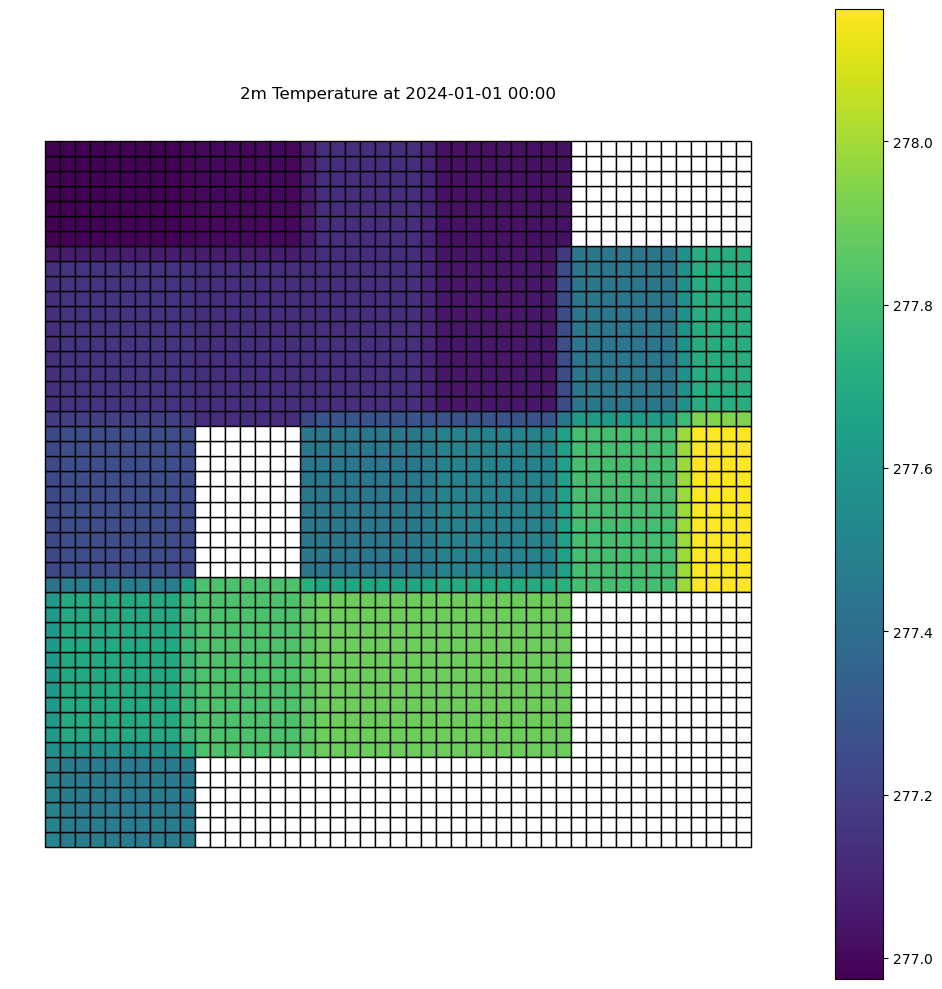

In [9]:
mask = (
    (result['date'] == pd.to_datetime('2024-01-01')) &
    (result['time'] == '0:00')
)
slice_0000 = result[mask]

fig, ax = plt.subplots(figsize=(10, 10))
slice_0000.plot(
    column='temperature_2m',
    legend=True,
    edgecolor='black',
    missing_kwds={'color': 'white'},
    ax=ax
)
ax.set_title('2m Temperature at 2024-01-01 00:00')
ax.set_axis_off()
plt.tight_layout()
plt.show()

In [10]:
# save to geojson
result.to_file('../data_nyc/era5_temp.geojson', driver='GeoJSON')
result.to_csv('../data_nyc/era5_temp.csv', index=False)